## Computing a ϕ(ρz) curve using a Monte Carlo
This notebook compares a simple model of the ionization cross-section with the more sophisticated model of Bote & Salvat by modeling a ϕ(ρz) curve using Monte Carlo simulation.

In [1]:
using NeXLCore, StaticArrays
using StatsBase

Use the standard crude model of the ionization cross-section used for most ϕ(ρz) models.

In [2]:
m(sh) = 0.86 + 0.12*exp(-(z(element(sh))/5)^2)
sigma(e, sh) = e>energy(sh) ? log(e/energy(sh))/ (((e/energy(sh))^m(sh))*energy(sh)^2) : 0.0

sigma (generic function with 1 method)

Also consider, the Bote 2009 model for the ionization cross-section.

In [3]:
sigma2(e,sh) = ionizationcrosssection(sh, e) 

sigma2 (generic function with 1 method)

Construct a simple accumlator to accumulate the relative number of ionizations per unit depth.

Define the model parameters. Let's consider the O K-L3 transition in Albite at 10 keV.

In [10]:
using NeXLMatrixCorrection

# Sample material, beam energy, characteristic X-ray
mat, e0, cxr = parse(Material, "NaAlSi3O8", density=1.0), 15.0e3, n"O K-L3"
# Shell and take-off angle
sh, toa = inner(cxr), deg2rad(40.0)
# reduced mass absorption coefficient
xi = χ(mat, cxr, toa)

5979.869708452221

In [5]:
randbetween(a::T,b::T) where {T<:Real} = a+(b-a)*rand(T)

randbetween (generic function with 1 method)

In [11]:
width = 1.0e-5 # Accumulator bin width
rz=collect(0.0:width:60*width)
prz, prza = Histogram(rz,Float64), Histogram(rz,Float64)
prz2, prza2 = Histogram(rz,Float64), Histogram(rz,Float64)
traj = 10000
# Normalize relative to a thin film of width
norm, norm2 = sigma(e0, sh)*traj*width, sigma2(e0,sh)*traj*width
for i in 1:traj
  # trajectory(...) excutes one full electron trajectory.  It stops at each scattering
  # point and runs the `do` code.
  trajectory(gun(Electron, e0, 1.0e-6), bulk(mat), minE=energy(inner(cxr))) do part, reg
     # Pick a randomized depth within the trajectory segment
     z = randbetween(part.current[3], part.previous[3])
     v = sigma(part.energy, sh)*NeXLCore.pathlength(part)/norm
     push!(prz, z, v)
     push!(prza, z, v*exp(-xi*z))
     v2 = sigma2(part.energy, sh)*NeXLCore.pathlength(part)/norm2
     push!(prz2, z, v2)
     push!(prza2, z, v2*exp(-xi*z))
  end
end

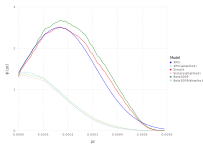

In [12]:
using Gadfly
set_default_plot_size(8inch,6inch)
mca = matrixcorrection(XPhi, mat, sh, e0)
plot(
  layer(x=rz[1:end-1], y=[ ϕ(mca, ρz) for ρz in rz[1:end-1] ], Geom.line,Theme( default_color="blue")),
  layer(x=rz[1:end-1], y=[ ϕabs(mca, ρz, cxr, toa) for ρz in rz[1:end-1] ], Geom.line,Theme( default_color="lightblue")),
  layer(x=rz[1:end-1], y=prz.weights, Geom.line,Theme( default_color="red")),
  layer(x=rz[1:end-1], y=prza.weights, Geom.line,Theme( default_color="pink")),
  layer(x=rz[1:end-1], y=prz2.weights, Geom.line,Theme( default_color="green")),
  layer(x=rz[1:end-1], y=prza2.weights, Geom.line,Theme( default_color="lightgreen")),
  Guide.manual_color_key("Model",["XPhi","XPhi(absorbed)", "Simple","Simple(absorbed)","Bote2009","Bote2009(absorbed)"],["blue","lightblue", "red","pink","green","lightgreen",]), Guide.xlabel("ρz"), Guide.ylabel("ϕ(ρz)"))


The A-term in the ZAF expression is just the ratio of the absorbed over the generated.

In [13]:
 sum(prza.weights) / sum(prz.weights), sum(prza2.weights) / sum(prz2.weights), A(mca, cxr,toa)

(0.3577748196813988, 0.3513867913880155, 0.3768094938811876)